In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# AR (Association Rules; 연관규칙)

## Step 1. Import the necessary libraries
- `mlxtend`: Machine learning extensions. Machine learning에 사용하는 알고리즘들을 제공하는 파이썬 라이브러리로, 연관규칙 분석 시 사용하는 함수도 포함.
- 대표적으로 `aprori` 와 `FP-growth` 방식이 있다.

In [ ]:
import pandas as pd
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

## Step 2. Import the dataset

### Dataset에 대한 소개
 Association Rules Mining에 사용한 데이터셋은 [kaggle](https://www.kaggle.com/datasets/sindraanthony9985/marketing-data-for-a-supermarket-in-united-states)에 있는 U.S. Supermarket Data를 활용하여 진행해보았다. 제공하고 있는 데이터셋 중 `Market_Basket_Optimisation.csv`를 이용해 AR을 진행해보았다.

 해당 데이터셋은 각 row 별로 한 번에 결제가 이루어진 상품을 담고 있다.

데이터셋을 사용하기에 앞서 각 row의 소비자들은 모두 다른 소비자라는 **한 가지 가정**을 하고 분석을 시작하였다. 따라서 동일 인물이 중복으로 구매한 경우는 고려되지 않았으며,

confidence, support, lift를 활용하는 AR 마이닝의 특성상 고객을 특정할 수 없는 경우에 가능한 가정이라고 판단하였다.

한 번에 가장 많이 상품을 구매한 경우는 총 20개를 구매한 첫 번째 row에 해당하는 소비자이고, 20개 만큼 구매품목이 다양하지 않은 소비자의 경우에는 NaN값으로 대체되어 있다.

In [ ]:
import pandas as pd
puchase = pd.read_csv("/content/drive/Shareddrives/22-1 데이터마이닝/data_week5/Market_Basket_Optimisation.csv", header = None)

- `header = None` 옵션을 추가한 이유는 아래 `data.head()`에서 확인 가능한  0번째 row가 header 부분으로 인식되지 않기 위해서이다.

In [ ]:
puchase.head() # 각 order의 내용 (item)에 대한 dataframe

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,chutney,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,turkey,avocado,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mineral water,milk,energy bar,whole wheat rice,green tea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Step 3. Preprocess the dataset to appropriate form for association rule mining
- `mlxtend`에서 제공하는 [`TransactionEncoder`](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/)을 사용하여 list 형식으로 구성된 거래 데이터를 2차원 numpy array로 변경  

### TransactionEncoder 사용 전 preprocessing

 `mlxtend`에서 제공하는 `TransactionEncoder`의 경우
 
 - list --> 2D array (numpy)

로 `type`의 변환이 일어나기 때문에 우선 거래 데이터를 `list` 형태로 만들어줄 필요가 있다.

우선 `NaN`값을 `integer 0`으로 대체해주고 각 행의 데이터 중 `integer 0`이 아닌 데이터만 불러온 새로운 리스트 `t_lst`를 만든다. 

In [ ]:
new = puchase.fillna(0)
new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,shrimp,almonds,avocado,vegetables mix,green grapes,whole weat flour,yams,cottage cheese,energy drink,tomato juice,low fat yogurt,green tea,honey,salad,mineral water,salmon,antioxydant juice,frozen smoothie,spinach,olive oil
1,burgers,meatballs,eggs,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,chutney,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,turkey,avocado,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,mineral water,milk,energy bar,whole wheat rice,green tea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7496,butter,light mayo,fresh bread,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7497,burgers,frozen vegetables,eggs,french fries,magazines,green tea,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7498,chicken,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7499,escalope,green tea,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
lst = new.values.tolist()

t_lst = []
i = 0

for row in lst:
  x = []
  for item in row:
      if item != 0:
        x.append(item)
        t_lst.append(x)

print(t_lst[:5]) # 리스트 상위 5개 줄만 출력

print("t_lst의 타입 :"+"{}".format(type(t_lst)))

[['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juice', 'low fat yogurt', 'green tea', 'honey', 'salad', 'mineral water', 'salmon', 'antioxydant juice', 'frozen smoothie', 'spinach', 'olive oil'], ['shrimp', 'almonds', 'avocado', 'vegetables mix', 'green grapes', 'whole weat flour', 'yams', 'cottage cheese', 'energy drink', 'tomato juic

### TransactionEncoder 사용

일반적으로 `fit_transform()`는 학습 데이터셋에 사용하여 fit과 transform 과정을 동시에 진행하게 된다.

본 실습에서는 dataset에 있는 라벨을 TransactionEncoder가 학습하는 동시에 `nested list` 형태의 input dataset을 `one-hot encoded Numpy Boolean array`로 변환시켜준다.

In [ ]:
te = TransactionEncoder()
te_ary = te.fit_transform(t_lst)
print(te_ary)

[[False  True  True ...  True False False]
 [False  True  True ...  True False False]
 [False  True  True ...  True False False]
 ...
 [False False False ... False  True False]
 [False False False ... False  True False]
 [False False False ... False  True False]]


`te_ary`는 `t_lst`에 존재하는 item들의 각 값들에 대해 one-hot encoding 방식으로 각 구매자(0,1,2,...)들에 대해 존재 유무를 표현한다.

이를 DataFrame type의 `df`로 바꾸어주자.

In [ ]:
df = pd.DataFrame(te_ary, columns=te.columns_) # label 정보는 te.columns_에 저장되어 있으므로, 해당 값을 칼럼명으로 하는 데이터 프레임으로 변경.
df.head()

,asparagus,almonds,antioxydant juice,asparagus,avocado,babies food,bacon,barbecue sauce,black tea,blueberries,...,turkey,vegetables mix,water spray,white wine,whole weat flour,whole wheat pasta,whole wheat rice,yams,yogurt cake,zucchini
0,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
1,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
2,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
3,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False
4,False,True,True,False,True,False,False,False,False,False,...,False,True,False,False,True,False,False,True,False,False


## Step 4. Association rule mining
- 연관분석 함수(`apriori, association_rules`)를 사용하여 분석 진행  
  - 지지도(support): 범용성 0.1
    - rule의 조건이 일어날 확률
    - 전체 중에서 상품 A가 몇 번이나 판매되었는가  
  $s(X→Y)=P(X \cap Y)$  

  - 신뢰도(confidence) 0.7
    - rule의 조건이 일어났을 때, 결과가 발생할 확률
    - A를 구입한 주문 중 B도 동시에 구입한 주문 수  
  $c(X → Y)=\frac{P(X \cap Y)}{P(X)}=P(B|A)$  

  - 향상도(lift) 
    - 조건과 결과가 각각 독립적이라고 가정할 경우보다 얼마나 더 좋은지를 평가
    - 두 상품의 관계를 직접적으로 나타낸 것  
   $Lift(X, Y)=\frac{P(A \cap B)}{P(A) \times P(B)}=\frac{P(B|A)}{P(B)}$  
    - X가 기본 아이템일 경우 항상 confidence가 1이 나오는 경우 두 아이템 간 관계를 파악할 수 없으므로 향상도를 비교

- 일반적으로 association rule을 사용하여 분석할 때는 다음과 같은 과정을 거침  
    1) 특정 지지도 이상인 set을 찾음  
    2) 해당 set의 조합으로 만들 수 있는 rule 중 신뢰도 이하의 rule을 screening out   
    3) 향상도를 정렬하여 rule을 평가

- 해석 시 유의할 점
  - item의 선/후 혹은 인과 관계는 알 수 없음
  - item별 수량은 고려되지 않음

## Aprori

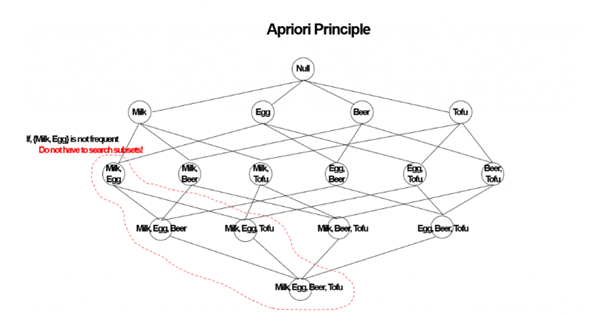

[출처] https://lucy-the-marketer.kr/ko/growth/association-rule-mining-overview/

Apriori 방법을 사용하는 경우 가장 먼저 전체 데이터 셋에서 최소 지지도 수준(분석가가 임의로 설정)을 만족하지 못하는 itemset이 존재하는 경우 해당 itemset을 포함하는 모든 itemset은 탐색이 이루어지지 않는다.

위의 이미지의 예시는 {Milk, Egg, Beer, Tofu} 중 {Milk, Egg}가 minimum support를 만족하지 못한 경우이고, {Milk, Egg}를 부분집합으로 갖는 다른 Node들을 제외한 나머지 부분에 대해서만 탐색을 진행하여도 된다.

### Minimum support 설정

기본적으로 `frequent_itemsets`를 지정하기 위한 기준으로 `minimum support`값을 활용한다.

일반적으로 0.1로 사용하기 때문에 관습을 따라 0.1 기준으로 `frequent_itemsets`을 확인해보았다.

In [ ]:
frequent_itemsets = apriori(df, min_support=0.1, use_colnames=True) # 초기 0.1 기준으로 선정
frequent_itemsets.sort_values(by='support', ascending=False)

,support,itemsets
12,0.353404,(mineral water)
16,0.282771,(spaghetti)
4,0.240575,(eggs)
3,0.238531,(chocolate)
5,0.222627,(french fries)
11,0.212615,(milk)
8,0.190137,(green tea)
9,0.168920,(ground beef)
7,0.160338,(frozen vegetables)
14,0.155127,(pancakes)


위의 출력 결과를 살펴보면 `min_support = 0.1`인 경우 스파게티와 물을 함께 구매한 경우 외에 모두 단일 품목들임을 알 수 있다. 때문에 지지도를 조금 낮추어 `min_support = 0.05`인 경우에 대해 다시 진행해보았다.

In [ ]:
frequent_itemsets = apriori(df, min_support=0.05, use_colnames=True) # 0.05 기준으로 수정
frequent_support = frequent_itemsets.sort_values(by='support', ascending=False).copy()
frequent_support

,support,itemsets
24,0.353404,(mineral water)
30,0.282771,(spaghetti)
10,0.240575,(eggs)
6,0.238531,(chocolate)
12,0.222627,(french fries)
...,...,...
35,0.051153,"(mineral water, cake)"
60,0.050812,"(olive oil, spaghetti)"
45,0.050778,"(french fries, green tea)"
21,0.050131,(hot dogs)


최소 지지도의 값을 0.05로 수정했을 때에 총 62개의 아이템셋으로 그 개수가 늘었고, 두 개의 아이템이 함께 담긴 경우도 관찰이 가능하다.

[해석] 관찰을 위해 상위 30개의 itemset을 살펴보았다.
- 단독으로는 mineral water 주문하는 경우가 가장 많다. (support = 0.353404)
- 2개의 itemset은 mineral water, spaghetti를 같이 구매한 경우가 가장 많았다. (support = 0.119981)
- 특히 support가 높은 2개 itemset에서는 mineral water가 함께 등장하는 경향이 관찰되었고, spaghetti, milk, chocolate, egg 순으로 주로 자주 식단이나 간식에 포함되는 상품이 함께 묶였음을 알 수 있었다.

In [ ]:
frequent_support.head(30)

,support,itemsets
24,0.353404,(mineral water)
30,0.282771,(spaghetti)
10,0.240575,(eggs)
6,0.238531,(chocolate)
12,0.222627,(french fries)
23,0.212615,(milk)
17,0.190137,(green tea)
18,0.168920,(ground beef)
15,0.160338,(frozen vegetables)
26,0.155127,(pancakes)


### Confidence

`association_rules()`를 활용해 사전에 minimum support 기준을 통과한 `frequent_itemsets`에 대해서 `confidence` 값을 계산한다.

관습적으로 0.7을 사용하므로 먼저 0.7에 대한 결과를 관찰해보자.

In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.7).sort_values(by = ['confidence', 'lift', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


아쉽게도 어떤 itemset도 해당되는경우가 없었다. 따라서 `min_threshold = 0.5`로 낮추어 진행해보았다.

In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5).sort_values(by = ['confidence', 'lift', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


다시 `min_threshold = 0.3`으로 낮추어보았다.

In [ ]:
association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3).sort_values(by = ['confidence', 'lift', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
13,(olive oil),(mineral water),0.114600,0.353404,0.056908,0.496582,1.405141,0.016408,1.284413
9,(ground beef),(mineral water),0.168920,0.353404,0.080544,0.476815,1.349205,0.020847,1.235883
10,(ground beef),(spaghetti),0.168920,0.282771,0.079624,0.471371,1.666972,0.031858,1.356772
11,(milk),(mineral water),0.212615,0.353404,0.097572,0.458914,1.298554,0.022433,1.194997
6,(frozen vegetables),(mineral water),0.160338,0.353404,0.072234,0.450510,1.274773,0.015570,1.176720
14,(pancakes),(mineral water),0.155127,0.353404,0.069203,0.446103,1.262304,0.014380,1.167358
17,(olive oil),(spaghetti),0.114600,0.282771,0.050812,0.443388,1.568011,0.018407,1.288562
0,(cake),(mineral water),0.120287,0.353404,0.051153,0.425255,1.203311,0.008643,1.125013
16,(spaghetti),(mineral water),0.282771,0.353404,0.119981,0.424304,1.200622,0.020049,1.123156
2,(chocolate),(mineral water),0.238531,0.353404,0.096584,0.404911,1.145747,0.012286,1.086554


confidence가 높게 등장한 antecedents와 consequents 관계부터 확인해보니
- olive oil을 구매한 경우 mineral water을 구매한 비율이 가장 높게 나타났다.
- 또한 ground beef를 구매한 경우 miineral water와 spaghetti를 함께 구매한 비율이 높게 등장했다.

전반적으로 antecedents와 consequents에 mineral water와 spaghetti가 빈번히 등장하는 모습도 관찰 가능했다.

### Lift

`Lift`값의 경우 1을 기준으로 해당 물건을 함께 구매할 가능성이 높거나 낮아진다고 판단할 수 있다. 1보다 큰 경우에 함께 구매할 확률이 높아지고, 1보다 작은 경우에는 반대로 함께 구매하지 않을 확률이 높아진다.

다음은 `Lift`에 따른 `antecedents`와 `consequents`들을 확인해보았다.

confidence와는 달리 antecedents와 consequents가 쌍으로 함께 나타나는데 이는 수식적 차이에서 발생하는 차이점이라고 볼 수 있다.

In [ ]:
association_rules(frequent_itemsets, metric="lift", min_threshold=1).sort_values(by = [ 'lift', 'confidence', 'support'], ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
30,(spaghetti),(ground beef),0.282771,0.168920,0.079624,0.281585,1.666972,0.031858,1.156824
31,(ground beef),(spaghetti),0.168920,0.282771,0.079624,0.471371,1.666972,0.031858,1.356772
42,(olive oil),(spaghetti),0.114600,0.282771,0.050812,0.443388,1.568011,0.018407,1.288562
43,(spaghetti),(olive oil),0.282771,0.114600,0.050812,0.179694,1.568011,0.018407,1.079353
22,(milk),(frozen vegetables),0.212615,0.160338,0.051187,0.240750,1.501515,0.017097,1.105909
23,(frozen vegetables),(milk),0.160338,0.212615,0.051187,0.319244,1.501515,0.017097,1.156634
36,(mineral water),(olive oil),0.353404,0.114600,0.056908,0.161029,1.405141,0.016408,1.055341
37,(olive oil),(mineral water),0.114600,0.353404,0.056908,0.496582,1.405141,0.016408,1.284413
28,(mineral water),(ground beef),0.353404,0.168920,0.080544,0.227908,1.349205,0.020847,1.076400
29,(ground beef),(mineral water),0.168920,0.353404,0.080544,0.476815,1.349205,0.020847,1.235883


## 결과 해석

본 데이터셋의 경우 실제 구매내역에 대한 데이터로 추후 아이템의 단순 노출 뿐만 아니라 소비자의 구매 여부(반응률)가 중요하기 때문에 Lift값이 크게 등장하는 값들 중 confidence가 높은 양의 상관관계를 갖는 상위 3개의 아이템셋을 정리해보았다.

1. (ground beef) -> (spaghetti)
  
  다진 쇠고기와 스파게티를 함께 구매할 가능성이 높게 나타났는데 이는 미트볼 스파게티 등의 요리에 활용하기 위한 소비자의 선택이라고 볼 수 있을 것이다.

2. (olive oil) -> (spaghetti)

  올리브 오일과 스파게티를 구매할 가능성이 높게 나타난 것으로 보아 오일 파스타 등을 만들기 위한 소비자의 선택이라고 볼 수 있을 것이다.

3. (frozen vegetables) -> (milk)

  냉동 과채류와 우유를 함께 구매할 가능성이 높게 나타났는데 이는 과채류를 넣은 스무디를 만들기 위한 선택이라고 볼 수 있을 것이다.

Aprori 방식은 모든 경우를 탐색하는 방식보다는 개선된 성능을 보이지만 결국 데이터베이스 전체를 읽고 계산해야 한다는 점 때문에 이를 개선한 FP-growth 방식이 등장했고, 계산적인 면에서 더 뛰어난 성과를 보인다고 알려져 있다.

https://lucy-the-marketer.kr/ko/growth/association-rule-mining-overview/

# Collabarative Filtering

### item-based에 적절한 형태로 데이터 구성

In [ ]:
data_a = pd.read_csv("/content/drive/Shareddrives/22-1 데이터마이닝/data_week5/anime.csv")
data_u = pd.read_csv("/content/drive/Shareddrives/22-1 데이터마이닝/data_week5/rating.csv")

In [ ]:
data_a.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


`animie.csv`를 일부 출력한 결과에서도 확인할 수 있듯이 애니메이션의 이름에 특수문자가 섞여 있는 부분이 있었다.

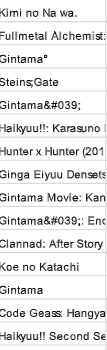

In [ ]:
data_u.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [ ]:
#rating안한 거 제외
data_u[data_u['rating'] > -1]

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


In [ ]:
data_new = data_u[data_u['rating'] > -1].copy()
data_new.shape

(6337241, 3)

In [ ]:
data_n = data_new.copy()

data_n = data_new.pop('rating')
data_n = pd.DataFrame(data_n)

In [ ]:
# 데이터를 줄이기 위한 split
from sklearn.model_selection import train_test_split

x_train, x_test, r_train, r_test = train_test_split(data_new, data_n, test_size = 0.2, random_state = 312, stratify=data_n)
x_train, x_valid, r_train, r_valid = train_test_split(x_train, r_train, test_size = 0.25, random_state = 312, stratify=r_train)
x_train2, x_test2, r_train2, r_test2 = train_test_split(x_test, r_test, test_size = 0.1, random_state = 312, stratify=r_test)
x_train2, x_valid2, r_train2, r_valid2 = train_test_split(x_train2, r_train2, test_size = 0.1, random_state = 312, stratify=r_train2)
x_train3, x_test3, r_train3, r_test3 = train_test_split(x_test2, r_test2, test_size = 0.1, random_state = 312, stratify=r_test2)
print("train set:",x_train3.shape)
print("test set:",x_test3.shape)#x_test3와 r_test3 사용

train set: (114070, 2)
test set: (12675, 2)


In [ ]:
# print("train set:",x_train.shape)
# print("valid set:",x_valid.shape)
# print("test set:",x_test.shape)

In [ ]:
# print("train set:",x_train2.shape)
# print("valid set:",x_valid2.shape)
# print("test set:",x_test2.shape)

In [ ]:
new_data = pd.concat([x_test3, r_test3], axis=1)
new_data

,user_id,anime_id,rating
7572156,70942,20745,6
280186,2912,12175,8
7517541,70340,19815,7
4733595,45206,889,8
4792042,45738,1122,8
...,...,...,...
7762549,73088,889,10
561474,5554,6213,10
2558443,24252,6377,7
3702869,34588,19369,6


In [ ]:
merge_inner = pd.merge(data_a,new_data, how='inner',on='anime_id')
merge_inner

,anime_id,name,genre,type,episodes,rating_x,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,3802,10
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,24865,9
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,11972,8
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,19070,8
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,36911,9
...,...,...,...,...,...,...,...,...,...
12670,4866,Pico x CoCo x Chico,"Hentai, Yaoi",OVA,1,5.16,27411,68204,10
12671,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,5.13,57355,28517,2
12672,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,5.13,57355,59966,10
12673,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,5.13,57355,7300,1


rating_x의 경우 anime_id에 대응되는 고유의 평균 평점이고, rating_y의 경우 사용자 평점 테이블에서 join된 열로 rating_y를 남기고 rating_x는 삭제해준다.

In [ ]:
df_new = merge_inner.drop(['rating_x'], axis = 1)
df_new

,anime_id,name,genre,type,episodes,members,user_id,rating_y
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,200630,3802,10
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,200630,24865,9
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,200630,11972,8
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,200630,19070,8
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,200630,36911,9
...,...,...,...,...,...,...,...,...
12670,4866,Pico x CoCo x Chico,"Hentai, Yaoi",OVA,1,27411,68204,10
12671,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,57355,28517,2
12672,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,57355,59966,10
12673,1639,Boku no Pico,"Hentai, Yaoi",OVA,1,57355,7300,1


In [ ]:
data_f = pd.get_dummies(df_new, columns=['genre', 'type'])

data_f.head()

,anime_id,name,episodes,members,user_id,rating_y,genre_Action,"genre_Action, Adventure","genre_Action, Adventure, Cars, Comedy, Sci-Fi, Shounen","genre_Action, Adventure, Comedy",...,genre_Slice of Life,"genre_Slice of Life, Supernatural",genre_Sports,genre_Supernatural,type_Movie,type_Music,type_ONA,type_OVA,type_Special,type_TV
0,32281,Kimi no Na wa.,1,200630,3802,10,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,32281,Kimi no Na wa.,1,200630,24865,9,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,32281,Kimi no Na wa.,1,200630,11972,8,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,32281,Kimi no Na wa.,1,200630,19070,8,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,32281,Kimi no Na wa.,1,200630,36911,9,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [ ]:
df_final = data_f.pivot_table('rating_y', index = 'user_id', columns = 'name')
df_final.head()

name,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,...,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- user들별로 평점을 주는 범위가 다르기 때문에 scaling하여 조정

In [ ]:
import numpy as np
df_final_scaled = df_final.apply(lambda x: (x-np.mean(x))/(np.max(x)-np.min(x)), axis=1)

In [ ]:
df_final_scaled

name,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Roots,.hack//Sign,.hack//Tasogare no Udewa Densetsu,...,ef: A Tale of Melodies.,ef: A Tale of Melodies. - Prologue,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73495,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73499,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
73502,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Item-based collaborative filtering
- Item*user으로 구성된 matrix를 사용하여 유사도 측정

In [ ]:
df_final_scaled = df_final_scaled.transpose().fillna(0)
df_final_scaled.head(5)

user_id,5,7,11,23,31,46,71,75,99,109,...,73460,73478,73485,73486,73494,73495,73499,73502,73507,73515
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//Gift,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


- user들 간 평점이 비슷한 정도를 기반으로 애니메이션들의 유사도 평가

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
anime_sim = cosine_similarity(df_final_scaled, df_final_scaled)
print(anime_sim.shape)

(2930, 2930)


In [ ]:
anime_sim = pd.DataFrame(anime_sim, index = df_final_scaled.index, columns = df_final_scaled.index)

In [ ]:
anime_sim['One Punch Man'].sort_values(ascending=False)[:10]

name
One Punch Man                                    1.000000
Full Metal Panic! The Second Raid Episode 000    0.330036
Carnival Phantasm EX Season                      0.206272
Gyakkyou Burai Kaiji: Ultimate Survivor          0.057534
&quot;Bungaku Shoujo&quot; Memoire               0.000000
Onegai☆Twins                                     0.000000
One Piece: Yume no Soccer Ou!                    0.000000
One Punch Man Specials                           0.000000
One Punch Man: Road to Hero                      0.000000
Oneechan ga Kita                                 0.000000
Name: One Punch Man, dtype: float64